In [1]:
import re
import json

In [2]:
from templates import extract_template

In [3]:
with open("grade_7x_subtitle.json", 'r') as f:
    subtitles = json.load(f)

In [4]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from typing import Annotated

In [5]:
from templates import *
from langchain_experimental.tools import PythonREPLTool
from langchain.tools import BaseTool, StructuredTool, tool

In [6]:
python_repl_tool = PythonREPLTool()

In [7]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                " {system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    # prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [8]:
@tool
def clean_up_response(
    answer: Annotated[str, "The problems and explanation pair for you to split them into separate pairs"],
):
    """Use this tool to extract problems-explanation pair from llm's response and store them in a list for clarity"""
    problem_explanation = []
    pattern = r"###\s*原题\s*：?([\s\S]*?)###\s*讲解\s*：?([\s\S]*?)(?=###|$)"
    matches = re.findall(pattern, answer)

    for i, match in enumerate(matches, 1):
        original, explanation = match
        problem_explanation.append([original, explanation])
    return problem_explanation

In [9]:
import operator
from langchain_core.messages import AIMessage

from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence, TypedDict


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [10]:
def agent_node(state, agent, name):
    result = agent.invoke(state)

    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        'messages': [result],
        'sender': name,
    }

In [11]:
import functools
llm = ChatOpenAI(model="gpt-4o")

extract_template = extract_template.format(subtitle=subtitles[22])
extractor_agent = create_agent(llm, [python_repl_tool], system_message=extract_template)
extractor_node = functools.partial(agent_node, agent=extractor_agent, name="Extractor")

validator_agent = create_agent(llm, [python_repl_tool], system_message=validator_template)
validator_node = functools.partial(agent_node, agent=validator_agent, name="Validator")

In [12]:
from langgraph.prebuilt import ToolNode

tools = [clean_up_response]
tool_node = ToolNode(tools)

In [13]:
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINISH" in last_message.content:
        return "__end__"
    return "continue"

In [14]:
workflow = StateGraph(AgentState)

workflow.add_node("Extractor", extractor_node)
workflow.add_node("Validator", validator_node)
# workflow.add_node("call_tool", tool_node)

workflow.add_edge("Extractor", "Validator")
workflow.add_edge("Validator", END)
workflow.add_edge(START, "Extractor")

graph = workflow.compile()

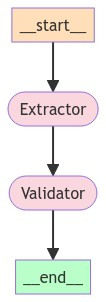

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
events = graph.astream(
    {
        "messages": [
            HumanMessage(
                content="请提取"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)

async for s in events:
    print(s, end="", flush=True)
    print("----")

{'Extractor': {'messages': [AIMessage(content='### 原题一：\n引力学校篮球联赛中每场比赛都要分出胜负，每队胜一场得二分一场得一分。某队在十场比赛中得到16分，那么这个队胜负场应分别是多少呢？\n\n### 讲解一：\n依据引力的问题，你能列一元一次方程吗？因为这个队伍参加十场比赛，所以设胜X场，则十减X场。又由于共得16分，所以\n\\[ 2X + (10 - X) = 16 \\]\n\n那你能不能根据题目直接设两个未知数使列方程变得容易呢？设这个队胜X场，负Y场。根据题意可以得：\n\\[ X + Y = 10 \\]\n\\[ 2X + Y = 16 \\]\n\n请大家观察这两个方程与一元一次方程有什么不同呢？它们有什么特点呢？每个方程都含有两个未知数，并含有未知数的项的次数都是一。像这样的方程称之为二元一次方程。\n\n类比一元一次方程的概念，我们得到二元一次方程的概念：含有两个未知数并且含有未知数的项的次数都是一的方程叫做二元一次方程。特别注意，含有未知数的项的次数都是一，即方程两边都是整式。\n\n### 原题二：\n利用二元一次方程的概念，请大家完成例一。\n\n### 讲解二：\n由于方程是关于X和Y的二元一次方程，所以X和Y是未知数，所以含有X或Y的项的次数应为一。因此，M加二应该等于一，所以M等于一。N减一应该等于一，所以N应该等于二。\n\n### 原题三：\n请大家依据二元一次方程组的概念判断下列方程组中哪些是二元一次方程组并说明为什么。\n\n### 讲解三：\n第一个方程组不是，因为它含有三个未知数。第二个方程组是，因为它含有两个未知数且含有每个未知数的项的次数都是一。同理，第三个也是。第四个方程组不是，因为在第二个方程中含未知数X的项的次数不是一，所以第四个不是二元一次方程组。因此B2应该选择二和三。\n\n### 原题四：\n引力中满足方程X加Y等于十且符合问题的实际意义的值有哪些呢？\n\n### 讲解四：\n因为XY为胜负场数，所以取值应该是0到10之间的非负整数。由表可知，X等于零，Y等于十；或X等于一，Y等于九等等，都是使方程X加Y等于十两边的值相等的解。它们都是方程的解。\n\n类比一元一次方程的解的概念，我们得到二元一次方程的解的概念：二元一次方程两边的值相等的两个未知